<AxesSubplot:xlabel='datetime'>

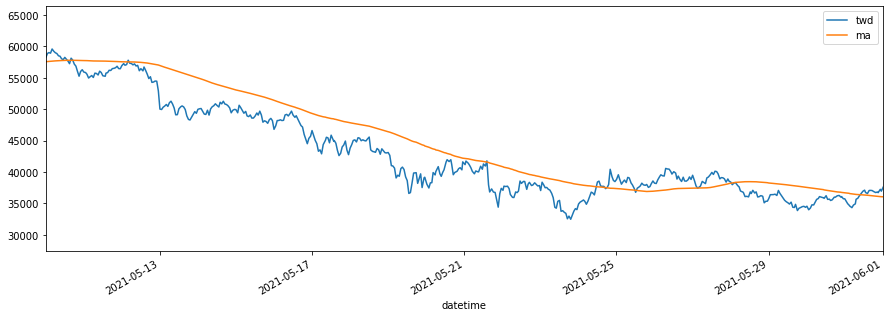

In [8]:
import requests
import pandas as pd

def get_price(url):
    res = requests.get(url)
    data_prices = res.json()['stats']
    df = pd.DataFrame(data_prices)
    df.columns = ['datetime','twd']
    df['datetime']=pd.to_datetime(df['datetime'],unit='ms')
    df.index=df['datetime']
    return df


url = 'https://www.coingecko.com/price_charts/1/usd/90_days.json'


bitcoin =get_price(url)
bitcoin['ma']=bitcoin['twd'].rolling(window=100).mean()
bitcoin[['twd','ma']].plot(kind = 'line',figsize=[15,5],xlim=('2021-05-10','2021-06-01'))

In [2]:
import requests

datestr = "20210729"

# 下載股價
r = requests.get(
    'https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + datestr + '&type=ALLBUT0999')

print(r.text)


"110年07月29日 價格指數(臺灣證券交易所)"
"指數","收盤指數","漲跌(+/-)","漲跌點數","漲跌百分比(%)","特殊處理註記",
"寶島股價指數","19,874.19","+","312.87","1.60","",
"發行量加權股價指數","17,402.81","+","267.59","1.56","",
"臺灣公司治理100指數","9,931.06","+","138.89","1.42","",
"臺灣50指數","13,549.72","+","175.64","1.31","",
"臺灣50權重上限30%指數","12,837.43","+","194.16","1.54","",
"臺灣中型100指數","14,078.90","+","254.98","1.84","",
"臺灣資訊科技指數","23,362.06","+","279.04","1.21","",
"臺灣發達指數","11,932.79","+","286.05","2.46","",
"臺灣高股息指數","7,706.40","+","57.84","0.76","",
"臺灣就業99指數","9,926.73","+","111.84","1.14","",
"臺灣高薪100指數","9,028.06","+","96.41","1.08","",
"未含金融指數","15,264.26","+","250.62","1.67","",
"未含電子指數","19,769.94","+","395.78","2.04","",
"未含金融電子指數","17,351.20","+","435.08","2.57","",
"小型股300指數","9,459.16","+","144.95","1.56","",
"水泥窯製類指數","839.96","+","14.03","1.70","",
"塑膠化工類指數","961.86","+","12.86","1.36","",
"機電類指數","4,589.19","+","57.67","1.27","",
"水泥類指數","207.23","+","1.66","0.81","",
"食品類指數","1,950.96","+","19.53","1.01","",
"塑膠類指數","287.66","

In [3]:
import requests
from io import StringIO
import pandas as pd

datestr = "20210201"
stock_symbol = "2330"

# 下載股價
r = requests.get(
    'https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + datestr + '&type=ALLBUT0999')

r_text = r.text.split('\n')

r_text = [i for i in r_text if len(
    i.split('",')) == 17 and i[0] != '=']

data = "\n".join(r_text)
df = pd.read_csv(StringIO(data), header=0)

df = df.drop(columns=['Unnamed: 16'])
filter_df = df[df["證券代號"] == stock_symbol]
print(filter_df)


     證券代號 證券名稱        成交股數    成交筆數            成交金額     開盤價     最高價     最低價  \
276  2330  台積電  70,161,939  81,346  42,004,241,697  595.00  612.00  587.00   

        收盤價 漲跌(+/-)  漲跌價差  最後揭示買價 最後揭示買量  最後揭示賣價 最後揭示賣量    本益比  
276  611.00       +  20.0  610.00    237  611.00    475  32.26  


In [4]:
import datetime

start_date_str = "20210125"
end_date_str = "20210201"

start_date = datetime.datetime.strptime(start_date_str, '%Y%m%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y%m%d')

totaldays = (end_date - start_date).days + 1
dates = []
for daynumber in range(totaldays):
    date = (start_date + datetime.timedelta(days=daynumber))
    if date.weekday() < 6:
        dates.append(date.strftime('%Y%m%d'))
print(dates)


['20210125', '20210126', '20210127', '20210128', '20210129', '20210130', '20210201']


In [11]:
import matplotlib.pyplot as plt
import crawler_module as m
from time import sleep
import pandas as pd
import mpl_finance as mpf
import talib

all_list = []
stock_symbol, dates = m.get_data()

for date in dates:
    sleep(5)
    try:
        crawler_data = m.crawl_data(date, stock_symbol)
        all_list.append(crawler_data[0])
        df_columns = crawler_data[1]
        print("  OK!  date = " + date + " ,stock symbol = " + stock_symbol)
    except:
        print("error! date = " + date + " ,stock symbol = " + stock_symbol)

all_df = pd.DataFrame(all_list, columns=df_columns)

# step 1 prepare data
day = all_df["日期"].astype(str)
openprice = all_df["開盤價"].astype(float)
close = all_df["收盤價"].astype(float)
high = all_df["最高價"].astype(float)
low = all_df["最低價"].astype(float)
volume = all_df["成交股數"].str.replace(',', '').astype(float)

# step 2 create plot
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(24, 15), dpi=100)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
ax.set_title(stock_symbol+"  K 線圖 ( " + dates[0] + " ~ " + dates[1] + " )")

# step 3 plot 子圖(ax)
mpf.candlestick2_ochl(ax, openprice, close, high, low, width=0.5,
                      colorup='r', colordown='g', alpha=0.6)
ax.plot(talib.SMA(close, 10), label='10日均線')
ax.plot(talib.SMA(close, 30), label='30日均線')
ax.legend(loc="best", fontsize=20)
ax.grid(True)

# step 3 plot 子圖(ax2)
mpf.volume_overlay(ax2, openprice, close, volume, colorup='r',
                   colordown='g', width=0.5, alpha=0.8)
ax2.set_xticks(range(0, len(day), 5))
ax2.set_xticklabels(day[::5])
ax2.grid(True)

# step 4 show plot
plt.show()


ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 44 from C header, got 40 from PyObject

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
print('123')

OSError: [WinError 193] %1 不是有效的 Win32 應用程式。

In [1]:
print('123')

123
